In [57]:
import re
import os
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from typing import List, Union, Tuple

In [2]:
def DMm_to_Dd(s: str, pattern: str) -> float:
    parsed = re.search(pattern=pattern, string=s, flags=re.IGNORECASE)
    D = int(parsed.group(1))
    M = int(parsed.group(2))
    m = parsed.group(3)

    # convert
    m = int(m) / 10**len(m)
    d = (M + m) / 60
    return D + d


def parse_UTC_time(s: str, pattern: str, offset: int) -> Tuple[int]:
    parsed = re.search(pattern=pattern, string=s)
    hour   = int(parsed.group(1))
    minute = int(parsed.group(2))
    second = int(parsed.group(3))
    return hour + offset, minute, second


def igc_parser(files: Union[str, List[str]], pattern: str = r"B([0-9]{6})([0-9]{7}[N, S])([0-9]{8}[W, E])([A, V])([0-9]{5})([0-9]{5})", 
               lat_pattern: str = r"([0-9]{2})([0-9]{2})([0-9]{3})[N, S]", long_pattern: str = r"([0-9]{3})([0-9]{2})([0-9]{3})[E, W]", 
               time_pattern: str = r"([0-9]{2})([0-9]{2})([0-9]{2})", offset: int = 0) -> pd.DataFrame:
    if isinstance(files, str):
        files = [files, ]

    points = []

    for file in files: 
        
        with open(file, "r") as igc_f:
            for line in igc_f:
                parsed = re.search(pattern=pattern, string=line.strip(), flags=re.IGNORECASE)

                if parsed is not None:
                    utc_time  = parsed.group(1)
                    latitude  = parsed.group(2)
                    longitude = parsed.group(3)
                    validity  = parsed.group(4)
                    press_alt = int(parsed.group(5))
                    gnss_alt  = int(parsed.group(6))

                    # convert latitude and longitude
                    latitude = DMm_to_Dd(latitude, lat_pattern)
                    longitude = DMm_to_Dd(longitude, long_pattern)

                    # convert UTC time to local time
                    hour, minute, second = parse_UTC_time(utc_time, time_pattern, offset)

                    point = (file, hour, minute, second, latitude, longitude, validity, press_alt, gnss_alt)
                    points.append(point)
    columns = ["igc_path", "hour", "minute", "second", "latitude", "longitude", "validity", "press_alt", "gnss_alt"]
    points = pd.DataFrame(points, columns=columns)
    return points

In [13]:
# parse igc files
root_dir = "./data/igc/"
igc_files = [os.path.join(root_dir, igc_file) for igc_file in os.listdir(root_dir)]
print("Всего файлов: %s" % len(igc_files))
points = igc_parser(files=igc_files, offset=3)
points = points.sort_values(by=["hour", "minute", "second"], ascending=[True, True, True]).reset_index(drop=True)

print("Всего точек: %s" % len(points))
display(points.head(2))

Всего файлов: 6
Всего точек: 2941


,igc_path,hour,minute,second,latitude,longitude,validity,press_alt,gnss_alt
0,./data/igc/part_3.igc,4,54,29,0.001183,0.001233,A,1147,463
1,./data/igc/part_3.igc,4,54,31,0.001183,0.001233,A,1144,463


In [14]:
points[["latitude", "longitude"]].agg(["min", "max"])

,latitude,longitude
min,0.000000,0.00000
max,54.683133,116.99475


Map latitude from 54.7382 to 54.5589
Map longitude from 37.8244 to 38.0635


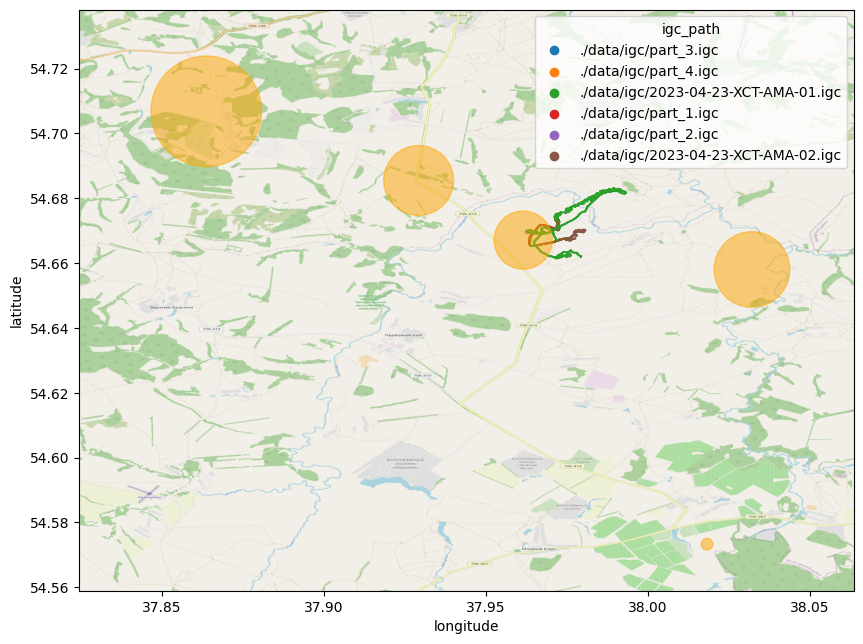

In [109]:
# open map from openstreetmap.org
ruh_m = plt.imread("./data/map.png")

# read map coordinates
with open("./data/map.txt", "r") as f:
    latitude_max, latitude_min, longitude_min, longitude_max = \
        tuple(map(float, f.readline().strip().split()))
print("Map latitude from %s to %s\nMap longitude from %s to %s" % (latitude_min, latitude_max, longitude_min, longitude_max))

fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(data=points, x="longitude", y="latitude", hue="igc_path", ax=ax, linewidth=0, s=2)
ax.imshow(ruh_m, zorder=0, extent=(longitude_min, longitude_max, latitude_max, latitude_min), aspect="equal")

# plot task
with open("./data/task.xctsk", "r") as task_f:
    task = json.load(task_f)

for waypoint in task["turnpoints"]:
    radius, waypoint = waypoint["radius"], waypoint["waypoint"]
    lat, lon = waypoint["lat"], waypoint["lon"]
    radius = radius / ((2 * np.pi * 6378.1) / 360)
    circle = Circle((lon, lat), radius / 1000, alpha=0.5, color="orange")
    ax.add_patch(circle)

# ax.set_xlim(54.64, 54.70)
# ax.set_ylim(37.95, 38.00);

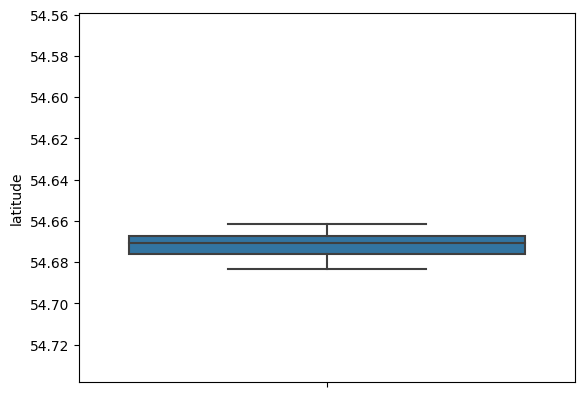

In [110]:
fig, ax = plt.subplots()
sns.boxplot(data=points, y="latitude", ax=ax)
plt.xticks(rotation=90)
ax.set_ylim(latitude_min, latitude_max);

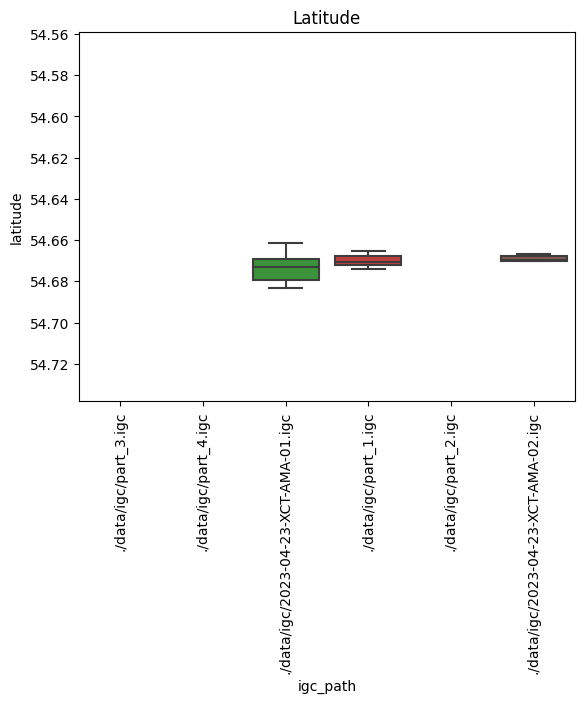

In [111]:
fig, ax = plt.subplots()
sns.boxplot(data=points, x="igc_path", y="latitude", ax=ax)
plt.xticks(rotation=90)
ax.set_ylim(latitude_min, latitude_max)
ax.set_title(label="Latitude");

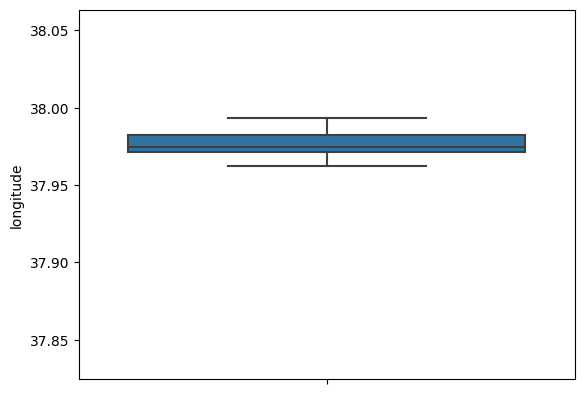

In [112]:
fig, ax = plt.subplots()
sns.boxplot(data=points, y="longitude", ax=ax)
plt.xticks(rotation=90)
ax.set_ylim(longitude_min, longitude_max);

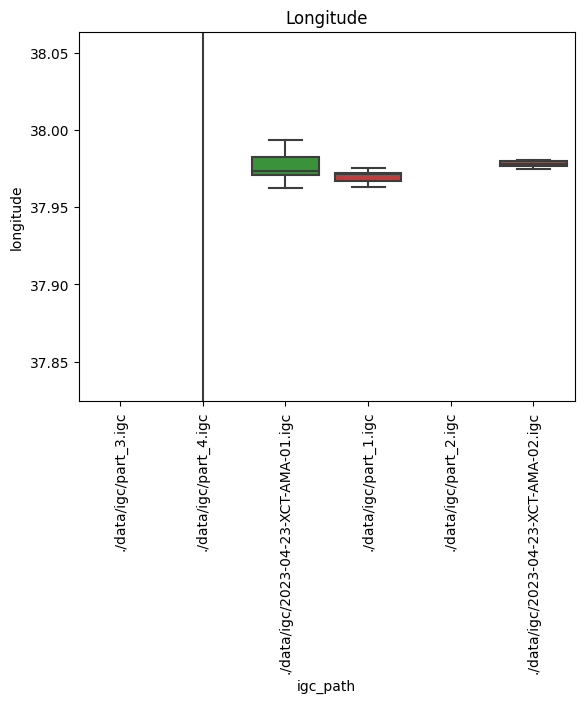

In [113]:
fig, ax = plt.subplots()
sns.boxplot(data=points, x="igc_path", y="longitude", ax=ax)
plt.xticks(rotation=90)
ax.set_ylim(longitude_min, longitude_max)
ax.set_title(label="Longitude");

# Join igc file

In [ ]:
IGC_FILES = [
    "./data/igc/2023-04-23-XCT-AMA-01.igc",
    "./data/igc/2023-04-23-XCT-AMA-02.igc",
]

# format time %H%M%S, Latitude D.d, Longitude D.d, Validity, Press Alt, GNSS Alt.
ADD_POINTS = [
    ()
]

HEADER = \
"""AXGD111 Flymaster F1, V1.5, S/N 2061
HFDTE230423
HOPLTPILOT: Andrei Makarovskii
HOGIDGLIDERID: None
HODTM100GPSDATUM: WGS-84
HOCIDCOMPETITIONID: None
HOCCLCOMPETITION CLASS: FAI-3
HFGTYGLIDERTYPE: BGD Cure 2
HOSITSite: None\n"""

TAIL = \
"""
LXGD GpsDump version 4.85
LXGD Downloaded 2023-04-23  18:46:20
G1621381DF8600364
"""